In [1]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from stop_words import get_stop_words
import warnings
print("Setup Complete")

Setup Complete


### Read mental health dataset from Kaggle as dataframe and analyze it

In [2]:
combined = pd.read_csv("data/combined_data.csv", index_col=0)

In [3]:
combined

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety
...,...,...
53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety
53039,"selfishness ""I don't feel very good, it's lik...",Anxiety
53040,Is there any way to sleep better? I can't slee...,Anxiety
53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety


In [4]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [5]:
# there are almost no missing values
missing_values = combined.isna().sum().div(combined.shape[0]).mul(100).to_frame().sort_values(by=0, ascending = False)
missing_values.columns  = ['% missing_values']
missing_values

,% missing_values
statement,0.682465
status,0.000000


In [6]:
status_count = combined.groupby("status").count()
status_count

,statement
status,
Anxiety,3841
Bipolar,2777
Depression,15404
Normal,16343
Personality disorder,1077
Stress,2587
Suicidal,10652


<Axes: ylabel='status'>

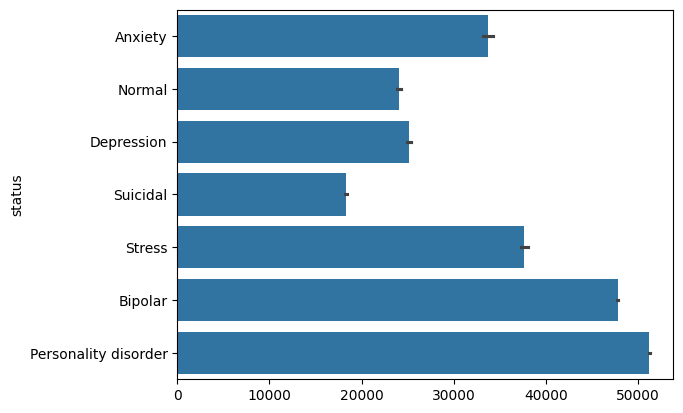

In [7]:
sns.barplot(data=combined['status'])

### Create bag of words matrix based on free text in statements

In [8]:
# see https://stackoverflow.com/questions/70719940/how-to-get-bag-of-words-and-term-frequency-in-text-format-using-sklearn
# https://scikit-learn.org/stable/modules/feature_extraction.html
statements = combined["statement"].fillna("").tolist()
stop_words = get_stop_words("en")
count_vec = CountVectorizer(stop_words=stop_words)
count_vec_fitted = count_vec.fit_transform(statements)
word_counts = count_vec_fitted.toarray()
words = count_vec.get_feature_names_out()
bag_of_words = pd.DataFrame(data=word_counts, columns=words)
bag_of_words.head()

/Users/michaelkrug/venv/ai/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'can', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


,00,000,0000,00000,000000,000000000,00000062,000002,00001,0001,...,ˆðÿ,α2,α3,ấy,𝗘𝘅𝗰𝗲𝗹𝗹𝗲𝗻𝗰𝗲,𝗛𝗼𝘀𝗽𝗶𝘁𝗮𝗹,𝗠𝗼𝗿𝗮𝗱𝗮𝗯𝗮𝗱,𝗧𝗿𝘂𝘀𝘁,𝗶𝗻,𝗿𝗲𝗴𝗶𝗼𝗻
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# filter columns by columns sums and regex
bag_of_words = bag_of_words.loc[:, bag_of_words.sum(axis=0) > 100] 
bag_of_words = bag_of_words[list(bag_of_words.filter(regex='[A-Za-z]'))]
bag_of_words.shape

(53043, 2734)

In [10]:
bag_of_words.head()

,20s,2nd,3rd,4th,abandoned,abilify,ability,able,abroad,absolute,...,yesterday,yet,yo,young,younger,youtube,zero,zoloft,zombie,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# join bow matrix to original dataset
combined = pd.concat([combined, bag_of_words], axis=1)

In [12]:
# check examples of bow matrix
combined[["status", "statement", "trouble", "mind", "good", "focus"]]

,status,statement,trouble,mind,good,focus
0,Anxiety,oh my gosh,0,0,0,0
1,Anxiety,"trouble sleeping, confused mind, restless hear...",1,1,0,0
2,Anxiety,"All wrong, back off dear, forward doubt. Stay ...",0,0,0,0
3,Anxiety,I've shifted my focus to something else but I'...,0,0,0,1
4,Anxiety,"I'm restless and restless, it's been a month n...",0,0,0,0
...,...,...,...,...,...,...
53038,Anxiety,Nobody takes me seriously I’ve (24M) dealt wit...,0,0,1,0
53039,Anxiety,"selfishness ""I don't feel very good, it's lik...",0,0,1,0
53040,Anxiety,Is there any way to sleep better? I can't slee...,0,0,0,0
53041,Anxiety,"Public speaking tips? Hi, all. I have to give ...",0,0,0,1


In [13]:
grouped = combined.copy()
grouped = grouped.drop("statement", axis=1)
grouped = grouped.groupby("status").sum()
grouped.head()

,20s,2nd,3rd,4th,abandoned,abilify,ability,able,abroad,absolute,...,yesterday,yet,yo,young,younger,youtube,zero,zoloft,zombie,zone
status,,,,,,,,,,,,,,,,,,,,,
Anxiety,13,6,11,15,3,5,22,331,4,23,...,212,182,21,100,36,24,21,73,6,16
Bipolar,16,14,15,8,7,162,47,363,10,26,...,103,175,6,40,22,32,33,59,25,12
Depression,89,46,51,47,87,22,185,1708,54,153,...,332,1063,60,385,240,138,182,167,49,41
Normal,2,17,6,0,4,0,7,146,9,8,...,114,157,19,54,16,36,6,8,2,9
Personality disorder,12,1,7,1,6,1,20,132,9,12,...,19,69,1,28,24,35,18,4,0,14


In [14]:
grouped.index

Index(['Anxiety', 'Bipolar', 'Depression', 'Normal', 'Personality disorder',
       'Stress', 'Suicidal'],
      dtype='object', name='status')

### Plot 

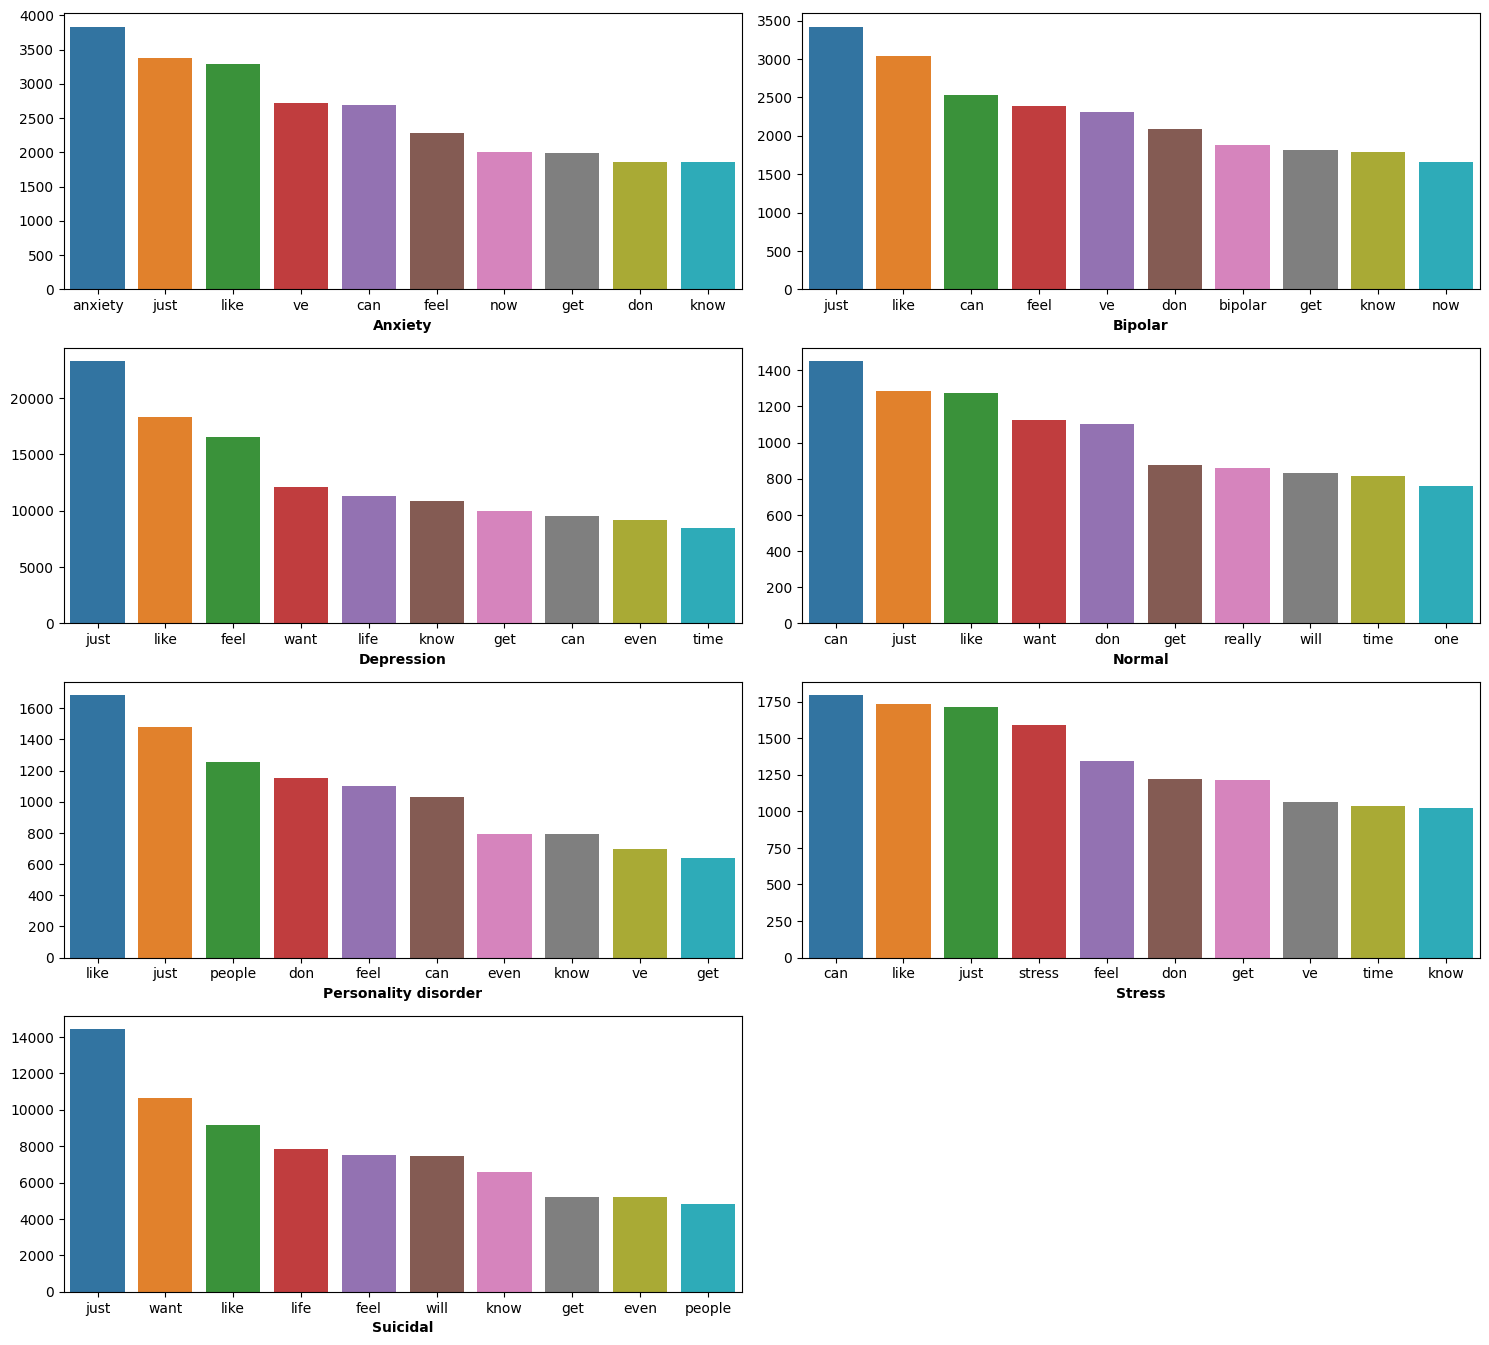

In [48]:
plt.figure(figsize=(15, 100))
for i, index_name in enumerate(grouped.index):
    plt.subplot(30, 2, i+1)
    grouped=grouped.sort_values(by=index_name, ascending=False, axis=1)
    data=grouped.filter(like=index_name, axis=0).iloc[:, : 10]
    sns.barplot(data)
    plt.xlabel(index_name, weight='bold')
    plt.tight_layout()